## Import Libraries

In [111]:
pip install pgmpy

In [112]:
# Import libraries
from pgmpy.models import BayesianModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pgmpy.factors.discrete import TabularCPD
import numpy as np

plt.style.use('ggplot')

## Definition of the Model

Since 2020 Covid-19 spread all around the World. Many computer scientists supported by medical experts have developed online platforms in which it is possible to assess the percentage of being positive based on multiple factors.

This project aims to recreate a simple online Covid-19 test that outputs the probability of being positive by leveraging a Bayesian Network.

The Network is composed of seven boolean variables:

- **Persistent_Cough**: the user has a persistent cough.
- **Loss_Taste**: the user has lost taste.
- **Loss_Smell**: the user has lost smell.
- **Over_Eighty**: the user is over 80 years old.
- **Vaccinated**: the user is vaccinated.
- **Live_With_Other_People**: the user lives with other people.
- **Potential_Symptoms**: this variable is conditioned on Persistent_Cough, Loss_Taste, Loss_Smell and Fever. It tells if the user has potential symptoms or not. It is introduced to group all the syntomps together and therefore to not overwhelm the other variables that affect the final variable Positive_To_Covid, which are Vaccinated and Live_With_Other_People.
- **Positive_To_Covid**: this variable is used to model the positiveness of the user to the virus. It is directly conditioned on Vaccinated, Live_With_Other_People, and Potential_Symptoms variables.

In [113]:
model = BayesianModel([('Potential_Symptoms', 'Positive_To_Covid'),
                       ('Live_With_Other_People', 'Positive_To_Covid'),
                       ('Vaccinated', 'Positive_To_Covid'),
                       ('Persistent_Cough', 'Potential_Symptoms'),
                       ('Fever_Above_38', 'Potential_Symptoms'),
                       ('Loss_Taste', 'Potential_Symptoms'),
                       ('Loss_Smell', 'Potential_Symptoms'),
                       ('Over_Eighty', 'Vaccinated'),
                       ('Over_Eighty', 'Live_With_Other_People')
                       ])

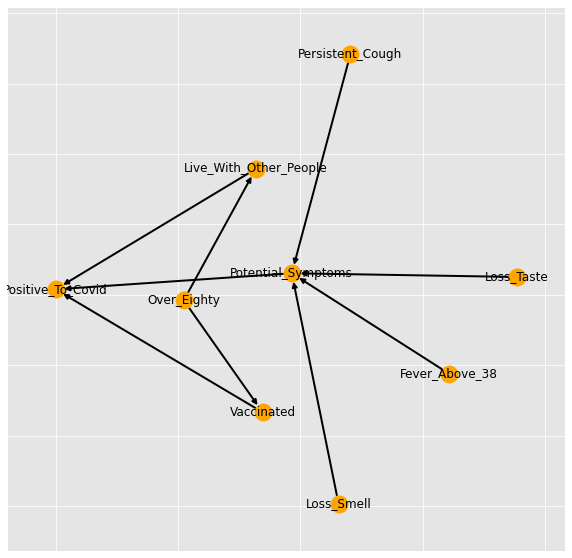

In [114]:
# network nodes and out-edges
nodes = list(model.nodes())
edges = list(model.edges())

DAG = nx.DiGraph()
DAG.add_edges_from(edges)
fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='orange')
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='black', width = 2, arrows=True)
plt.show()

## Conditional Probability Tables (CPT)

In [115]:
# loss of taste
loss_taste_cdp = TabularCPD(variable='Loss_Taste', variable_card=2, 
                            values=[[0.9], [0.1]],
                            state_names={'Loss_Taste': ['No', 'Yes']})

# loss of smell
loss_smell_cdp = TabularCPD(variable='Loss_Smell', variable_card=2, 
                            values=[[0.85], [0.15]],
                            state_names={'Loss_Smell': ['No', 'Yes']})

# fever above 38°C
fever_cdp = TabularCPD(variable='Fever_Above_38', variable_card=2, 
                            values=[[0.82], [0.18]],
                            state_names={'Fever_Above_38': ['No', 'Yes']})

# hasn not/has persistent cough
cough_cpd = TabularCPD(variable='Persistent_Cough', variable_card=2, values=[[0.75], [0.25]],
                       state_names={'Persistent_Cough': ['No', 'Yes']})

# is not/is over eighty
over_eighty_cpd = TabularCPD(variable='Over_Eighty', variable_card=2, 
                             values=[[0.85], [0.15]],
                             state_names={'Over_Eighty': ['No', 'Yes']})

# is not/is vaccinated, given over eighty
vaccinated_cpd = TabularCPD(variable='Vaccinated', variable_card=2, 
                            values=[[0.90, 0.30],
                                    [0.10, 0.70]],
                            evidence=['Over_Eighty'],
                            evidence_card=[2],
                            state_names={'Vaccinated': ['No', 'Yes'],
                                         'Over_Eighty': ['No', 'Yes']})

# live with other people
live_with_other_people_cpd = TabularCPD(variable='Live_With_Other_People', 
                            variable_card=2, 
                            values=[[0.35, 0.42],
                                    [0.65, 0.58]],
                            evidence=['Over_Eighty'],
                            evidence_card=[2],
                            state_names={'Live_With_Other_People': ['No', 'Yes'],
                                        'Over_Eighty': ['No', 'Yes']})

# has potential symptoms
symptoms_cpd = TabularCPD(variable='Potential_Symptoms', 
                            variable_card=2, 
                            values=[[0.98, 0.33, 0.60, 0.10, 0.80, 0.28, 0.40, 0.06,
                                     0.31, 0.13, 0.09, 0.04, 0.26, 0.10, 0.04, 0.02],
                                    [0.02, 0.67, 0.40, 0.90, 0.20, 0.72, 0.60, 0.94,
                                     0.69, 0.87, 0.91, 0.96, 0.74, 0.90, 0.96, 0.98]],
                            evidence=['Loss_Taste', 'Persistent_Cough', 
                                      'Fever_Above_38', 'Loss_Smell'],
                            evidence_card=[2, 2, 2, 2],
                            state_names={'Loss_Taste': ['No', 'Yes'],
                                         'Persistent_Cough': ['No', 'Yes'],
                                         'Fever_Above_38': ['No', 'Yes'],
                                         'Potential_Symptoms': ['No', 'Yes'],
                                         'Loss_Smell': ['No', 'Yes']})

# is positive to Covid
positive_to_covid_cpd = TabularCPD(variable='Positive_To_Covid', 
                            variable_card=2, 
                            values=[[0.85, 0.98, 0.25, 0.75, 0.7, 0.92, 0.05, 0.64],
                                    [0.15, 0.02, 0.75, 0.25, 0.3, 0.08, 0.95, 0.36]],
                            evidence=['Live_With_Other_People','Potential_Symptoms','Vaccinated'],
                            evidence_card=[2, 2, 2],
                            state_names={'Live_With_Other_People': ['No', 'Yes'],
                                         'Potential_Symptoms': ['No', 'Yes'],
                                         'Vaccinated': ['No', 'Yes'],
                                         'Positive_To_Covid': ['No', 'Yes']})

In [116]:
# Add the Conditional Probability Tables to the model
model.add_cpds(loss_taste_cdp,
               loss_smell_cdp,
               fever_cdp,
               cough_cpd,
               over_eighty_cpd,
               vaccinated_cpd,
               live_with_other_people_cpd,
               symptoms_cpd,
               positive_to_covid_cpd)
model.check_model()

True

### Viewing the Conditional Probability Tables

In [117]:
# Print the Conditional Probability Tables
print('CPT - Loss_Taste')
print(loss_taste_cdp)
print()

print('CPT - Loss_Smell')
print(loss_smell_cdp)
print()

print('CPT - Fever')
print(fever_cdp)
print()

print('CPT - Persistent_Cough')
print(cough_cpd)
print()

print('CPT - Over_Eighty')
print(over_eighty_cpd)
print()

print('CPT - Vaccinated')
print(vaccinated_cpd)
print()

print('CPT - Live_With_Other_People')
print(live_with_other_people_cpd)
print()

print('CPT - Potential_Symptoms')
print(symptoms_cpd)
print()

print('CPT - Positive_To_Covid')
print(positive_to_covid_cpd)
print()

CPT - Loss_Taste
+-----------------+-----+
| Loss_Taste(No)  | 0.9 |
+-----------------+-----+
| Loss_Taste(Yes) | 0.1 |
+-----------------+-----+

CPT - Loss_Smell
+-----------------+------+
| Loss_Smell(No)  | 0.85 |
+-----------------+------+
| Loss_Smell(Yes) | 0.15 |
+-----------------+------+

CPT - Fever
+---------------------+------+
| Fever_Above_38(No)  | 0.82 |
+---------------------+------+
| Fever_Above_38(Yes) | 0.18 |
+---------------------+------+

CPT - Persistent_Cough
+-----------------------+------+
| Persistent_Cough(No)  | 0.75 |
+-----------------------+------+
| Persistent_Cough(Yes) | 0.25 |
+-----------------------+------+

CPT - Over_Eighty
+------------------+------+
| Over_Eighty(No)  | 0.85 |
+------------------+------+
| Over_Eighty(Yes) | 0.15 |
+------------------+------+

CPT - Vaccinated
+-----------------+-----------------+------------------+
| Over_Eighty     | Over_Eighty(No) | Over_Eighty(Yes) |
+-----------------+-----------------+---------------

## Viewing Independences

In [118]:
print(model.local_independencies('Vaccinated'))
print(model.local_independencies('Potential_Symptoms'))
print(model.local_independencies('Positive_To_Covid'))

(Vaccinated _|_ Live_With_Other_People, Potential_Symptoms, Fever_Above_38, Loss_Smell, Loss_Taste, Persistent_Cough | Over_Eighty)
(Potential_Symptoms _|_ Over_Eighty, Live_With_Other_People, Vaccinated | Loss_Taste, Loss_Smell, Fever_Above_38, Persistent_Cough)
(Positive_To_Covid _|_ Over_Eighty, Fever_Above_38, Loss_Smell, Loss_Taste, Persistent_Cough | Vaccinated, Live_With_Other_People, Potential_Symptoms)


## Exact Inference - Variable Elimination

In [119]:
from pgmpy.inference import VariableElimination

exact_inference = VariableElimination(model)

# the prior probability distribution of Positive_To_Covid
query1 = exact_inference.query(['Positive_To_Covid'])
print('\nP(Positive_To_Covid)\n\n', query1)



  0%|          | 0/8 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 8/8 [00:00<00:00, 891.55it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Potential_Symptoms:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Fever_Above_38:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Loss_Smell:   0%|          | 0/8 [00:00<?, ?it/s]    

Eliminating: Loss_Taste:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Live_With_Other_People:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Over_Eighty:   0%|          | 0/8 [00:00<?, ?it/s]           

Eliminating: Vaccinated:   0%|          | 0/8 [00:00<?, ?it/s] 

Eliminating: Persistent_Cough:   0%|          | 0/8 [00:00<?, ?it/s]

Eliminating: Persistent_Cough: 100%|██████████| 8/8 [00:00<00:00, 73.63it/s]


P(Positive_To_Covid)

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.6337 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.3663 |
+------------------------+--------------------------+


In [120]:
query2 = exact_inference.query(['Positive_To_Covid'],{'Potential_Symptoms':'Yes'})
print('\n\nP( Positive_To_Covid | Potential_Symptoms = Yes )\n\n', query2)



  0%|          | 0/7 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 7/7 [00:00<00:00, 920.96it/s]


  0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Live_With_Other_People:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Over_Eighty:   0%|          | 0/7 [00:00<?, ?it/s]           

Eliminating: Fever_Above_38:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Vaccinated:   0%|          | 0/7 [00:00<?, ?it/s]    

Eliminating: Loss_Smell:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Loss_Taste:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Persistent_Cough: 100%|██████████| 7/7 [00:00<00:00, 188.53it/s]



P( Positive_To_Covid | Potential_Symptoms = Yes )

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.2276 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.7724 |
+------------------------+--------------------------+


In [121]:
query2 = exact_inference.query(['Positive_To_Covid'],{'Vaccinated':'Yes'})
print('\n\nP( Positive_To_Covid | Vaccinated = Yes )\n\n', query2)



  0%|          | 0/7 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 7/7 [00:00<00:00, 972.71it/s]


  0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Live_With_Other_People:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Over_Eighty:   0%|          | 0/7 [00:00<?, ?it/s]           

Eliminating: Potential_Symptoms:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Fever_Above_38:   0%|          | 0/7 [00:00<?, ?it/s]    

Eliminating: Loss_Smell:   0%|          | 0/7 [00:00<?, ?it/s]    

Eliminating: Loss_Taste:   0%|          | 0/7 [00:00<?, ?it/s]

Eliminating: Persistent_Cough: 100%|██████████| 7/7 [00:00<00:00, 113.92it/s]



P( Positive_To_Covid | Vaccinated = Yes )

 +------------------------+--------------------------+
| Positive_To_Covid      |   phi(Positive_To_Covid) |
+========================+==========================+
| Positive_To_Covid(No)  |                   0.8712 |
+------------------------+--------------------------+
| Positive_To_Covid(Yes) |                   0.1288 |
+------------------------+--------------------------+


In [122]:
query4 = exact_inference.map_query(['Over_Eighty', 'Live_With_Other_People',
                                    'Vaccinated'], {'Positive_To_Covid':'Yes'}) 
print('\n\nMAP of Positive_To_Covid = \"Yes\" \n\n', query4)



  0%|          | 0/5 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 5/5 [00:00<00:00, 991.14it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

Eliminating: Potential_Symptoms:   0%|          | 0/5 [00:00<?, ?it/s]

Eliminating: Fever_Above_38:   0%|          | 0/5 [00:00<?, ?it/s]    

Eliminating: Loss_Smell:   0%|          | 0/5 [00:00<?, ?it/s]    

Eliminating: Loss_Taste:   0%|          | 0/5 [00:00<?, ?it/s]

Eliminating: Persistent_Cough: 100%|██████████| 5/5 [00:00<00:00, 86.35it/s]




MAP of Positive_To_Covid = "Yes" 

 {'Over_Eighty': 'No', 'Live_With_Other_People': 'Yes', 'Vaccinated': 'No'}


## Approximate Inference

In [123]:
query = exact_inference.query(['Vaccinated'], {'Over_Eighty' : 'Yes','Positive_To_Covid' : 'No'})
print('\n\n\nExact Inference:')
print("\nP(Vaccinated | Over_Eighty = \"Yes\", Positive_To_Covid = \"No\")\n\n", query)

reference_prob = query.values[1]



  0%|          | 0/6 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 6/6 [00:00<00:00, 1026.72it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Eliminating: Live_With_Other_People:   0%|          | 0/6 [00:00<?, ?it/s]

Eliminating: Potential_Symptoms:   0%|          | 0/6 [00:00<?, ?it/s]    

Eliminating: Fever_Above_38:   0%|          | 0/6 [00:00<?, ?it/s]    

Eliminating: Loss_Smell:   0%|          | 0/6 [00:00<?, ?it/s]    

Eliminating: Loss_Taste:   0%|          | 0/6 [00:00<?, ?it/s]

Eliminating: Persistent_Cough: 100%|██████████| 6/6 [00:00<00:00, 120.68it/s]




Exact Inference:

P(Vaccinated | Over_Eighty = "Yes", Positive_To_Covid = "No")

 +-----------------+-------------------+
| Vaccinated      |   phi(Vaccinated) |
+=================+===================+
| Vaccinated(No)  |            0.2242 |
+-----------------+-------------------+
| Vaccinated(Yes) |            0.7758 |
+-----------------+-------------------+


In [124]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
from pgmpy.sampling import GibbsSampling

In [125]:
BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"


In [126]:
def get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS):
    wl = abs(reference_prob - results_WL[-1])
    rs = abs(reference_prob - results_RS[-1])
    gs = abs(reference_prob - results_GS[-1])
    if wl < rs and wl < gs:
        print('The best method is WL with a difference wrt the reference value of: {}'.format(wl))
    elif rs < wl and rs < gs:
        print('The best method is RS with a difference wrt the reference value of: {}'.format(rs))
    else:
        print('The best method is GS with a difference wrt the reference value of: {}'.format(gs))

def weighted_likelihood_prob(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def gibbs_sampling(samples):
    return (samples.query('Vaccinated == 1 & Over_Eighty == 1 & Positive_To_Covid == 0').shape[0]
                /
            samples.query('Over_Eighty == 1 & Positive_To_Covid == 0').shape[0])
    
def run(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')
    samples_GS= gibbs.sample(size = size)
    
    # Probability
    results_WL = weighted_likelihood_prob(samples_WL,'Vaccinated')
    results_RS = np.recarray.mean(samples_RS['Vaccinated'], axis=0)
    results_GS = gibbs_sampling(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])

approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])

In [127]:
initial_size = 2
final_size = 5
num = 10
evidence = [State('Over_Eighty', 'Yes'), State('Positive_To_Covid', 'No')]

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results, run(size))
    
sizes = approximate_results['sample_size']
results_WL = approximate_results['WL']
results_RS = approximate_results['RS']
results_GS = approximate_results['GS']

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:519: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"


  0%|          | 0/100 [00:00<?, ?it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Over_Eighty:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Live_With_Other_People:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Vaccinated:   0%|          | 0/9 [00:00<?, ?it/s]            


Generating for node: Loss_Smell:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Loss_Taste:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Fever_Above_38:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Persistent_Cough:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for node: Potential_Symptoms:   0%|          | 0/9 [00:00<?, ?it/s]


Generating for no

In [128]:
get_best_sampling_method(reference_prob, results_WL, results_RS, results_GS)

The best method is RS with a difference wrt the reference value of: 0.0009685790660808324


In [129]:
print(approximate_results)

[(   100, 0.8 , 0.78      , 0.91666667)
 (   215, 0.79, 0.77209302, 0.64      )
 (   464, 0.76, 0.74784483, 0.69387755)
 (  1000, 0.79, 0.793     , 0.80555556)
 (  2154, 0.78, 0.78737233, 0.75984252)
 (  4641, 0.78, 0.77138548, 0.76311031)
 ( 10000, 0.77, 0.7716    , 0.77604167)
 ( 21544, 0.77, 0.77840698, 0.7711575 )
 ( 46415, 0.77, 0.77735646, 0.76122412)
 (100000, 0.78, 0.77488   , 0.78674719)]


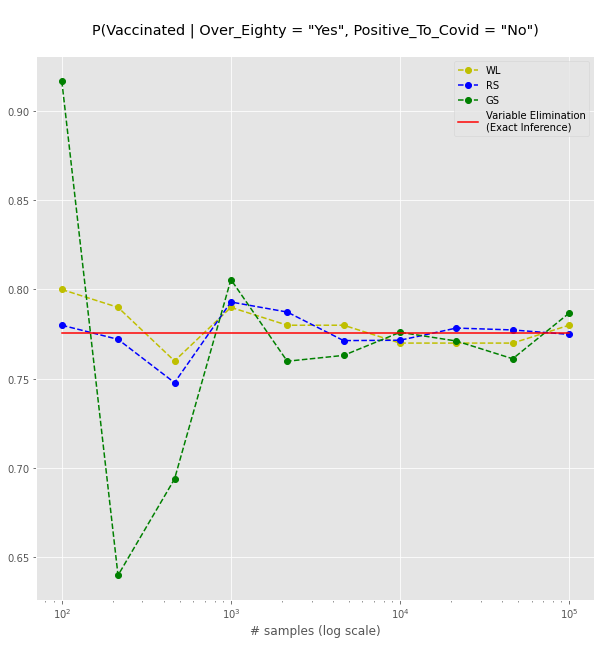

In [130]:
# Compare the results

plt.figure(figsize=(10,10))
plt.grid(True)
plt.title('\nP(Vaccinated | Over_Eighty = "Yes", Positive_To_Covid = "No")\n')
plt.xlabel("# samples (log scale)")

sizes = approximate_results['sample_size']

plot_WL, = plt.semilogx(sizes, results_WL, 'yo--', label="WL")
plot_RS, = plt.semilogx(sizes, results_RS, 'bo--', label="RS")
plot_GS,= plt.semilogx(sizes, results_GS, 'go--', label="GS")
plot_VE,= plt.semilogx(sizes, reference_prob*np.ones(len(sizes)),'r', label="Variable Elimination\n(Exact Inference)")

plt.legend(handles=[plot_WL, plot_RS, plot_GS, plot_VE])
plt.show()